Nom des membres du groupe : <br>
    - Tonfack Ngouadjeu Dunant  (Université Paul Sabatier groupe Tp : INXID51A11)<br>
    - Gihalu Russel Gamwangu  (Université Paul Sabatier groupe Tp : INXID51B11)<br>

X_train : (1057, 21001)
y_train : (1057, 1001)
X_test  : (1057, 38141)

5 premières lignes de X_train 
              Horodate  5423908671  2568793410  8310762594  6235194807  \
0  2023-01-09 00:00:00       352.0         0.0       371.0       110.0   
1  2023-01-09 00:30:00       405.0         0.0       363.0       108.0   
2  2023-01-09 01:00:00       599.0         0.0       352.0        93.0   
3  2023-01-09 01:30:00       315.0         0.0       348.0        84.0   
4  2023-01-09 02:00:00       448.0         0.0       364.0        73.0   

   423895617  193845276  216589743  218753964  1794650328  ...  holed_991  \
0      724.0      102.0      256.0        7.0       105.0  ...        0.0   
1      478.0      147.0      281.0        8.0       134.0  ...        0.0   
2      832.0      155.0      295.0        5.0        96.0  ...        0.0   
3      574.0      152.0      267.0       15.0       156.0  ...        0.0   
4      421.0      176.0      346.0       38.0        97.0  ...     

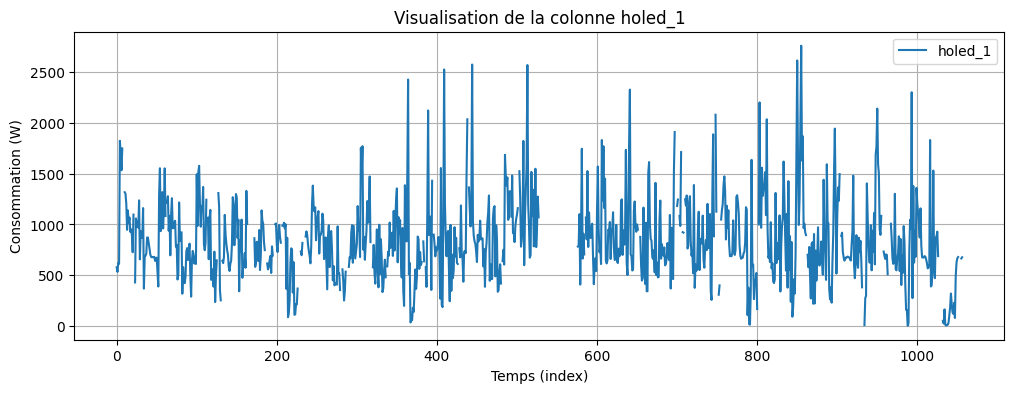


-------------Exemple de reconstruction de donnees avec l'interpolation

MAE interpolation linéaire sur holed_1 : 29.2111



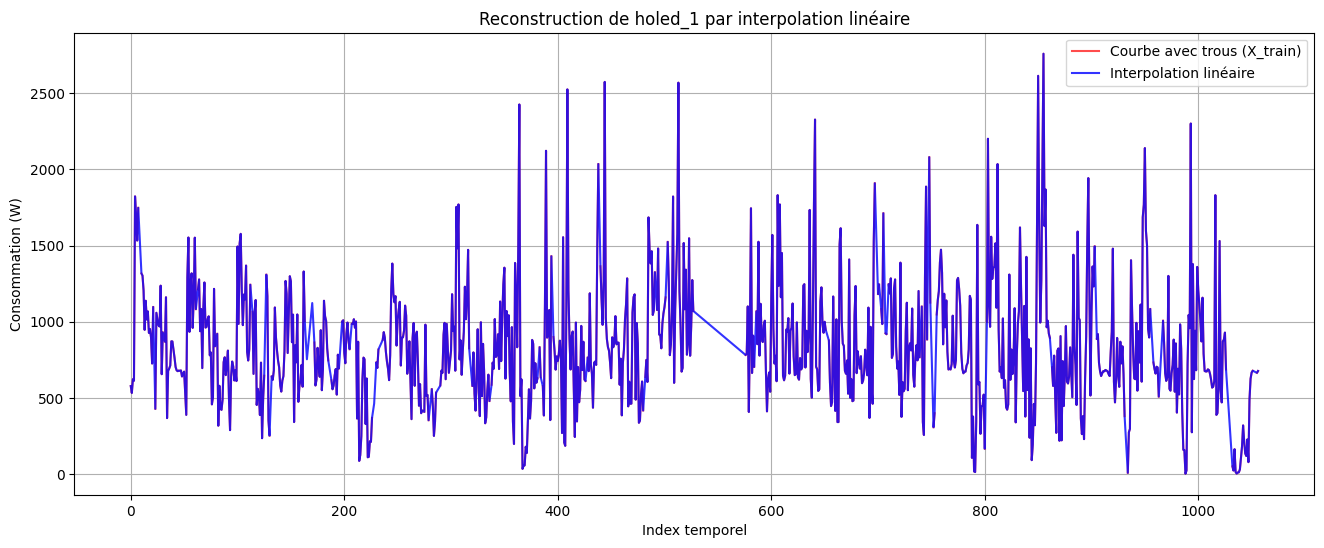

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt

X_train = pd.read_csv("X_train_78VdSWL.csv")
y_train = pd.read_csv("y_train_u0UkKEh.csv")
X_test  = pd.read_csv("X_test_XKVc4no.csv")

print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test  :", X_test.shape)

print("\n5 premières lignes de X_train ")
print(X_train.head())

print("\nColonnes contenant des NaN")
print(X_train.columns[X_train.isna().any()].tolist())

# Exemple : afficher la courbe holed_1 si elle existe
column_name = "holed_1"

if column_name in X_train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(X_train[column_name], label=column_name)
    plt.title(f"Visualisation de la colonne {column_name}")
    plt.xlabel("Temps (index)")
    plt.ylabel("Consommation (W)")
    plt.grid()
    plt.legend()
    plt.show()
else:
    print(f"La colonne {column_name} n'existe pas dans X_train.")
    
print("\n-------------Exemple de reconstruction de donnees avec l'interpolation--------------------------------------------")
col = "holed_1"
# Interpolation
def fill_nan_with_interpolation(column):
    col_copy = column.copy()
    col_copy = col_copy.interpolate(method="linear", limit_direction="both")
    return col_copy

col_pred = fill_nan_with_interpolation(X_train[col])

true_values = y_train[col].values
pred_values = col_pred.values

#Calcul de la mae
mae = np.mean(np.abs(true_values - pred_values))
print(f"\nMAE interpolation linéaire sur {col} : {mae:.4f}\n")

plt.figure(figsize=(16, 6))
plt.plot(X_train[col], label="Courbe avec trous (X_train)", color="red", alpha=0.7)
plt.plot(col_pred, label="Interpolation linéaire", color="blue", alpha=0.8)
plt.title(f"Reconstruction de {col} par interpolation linéaire")
plt.xlabel("Index temporel")
plt.ylabel("Consommation (W)")
plt.legend()
plt.grid(True)
plt.show()

    


MLP Global : On entraîne le model une fois et on le fait prédire les valeurs manquantes

In [ ]:
import os                                                  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import models, layers


# paramètres généraux
WINDOW = 10
EPOCHS = 20      
BATCH = 64
N_COLS_SAMPLE = 300

X_train = pd.read_csv("X_train_78VdSWL.csv")
y_train = pd.read_csv("y_train_u0UkKEh.csv")

nb_holed = len([c for c in X_train.columns if c.startswith("holed_")])
nb_full  = len(X_train.columns) - nb_holed

print(f"\nColonnes trouées   : {nb_holed}")
print(f"Colonnes complètes : {nb_full}")

# colonnes complètes disponibles pour l'entraînement
full_cols = [
    c for c in X_train.columns 
    if not c.startswith("holed_") and c != "Horodate"
][:N_COLS_SAMPLE]

print(f"\nColonnes utilisees pour entrainer le MLP : {len(full_cols)}")

# création des fenêtres temporelles
def creer_fenetres(serie, window):
    X_list, y_list = [], []
    for t in range(window, len(serie) - window):
        left  = serie[t-window:t]
        right = serie[t+1:t+1+window]
        x = np.concatenate([left, right])
        y = serie[t]
        X_list.append(x)
        y_list.append(y)
    return np.array(X_list), np.array(y_list)


# construction du dataset global
X_all, y_all = [], []

print("\nConstruction du dataset global…")
for col in tqdm(full_cols, desc="Extraction des fenêtres"):
    serie = X_train[col].values.astype("float32")
    X_win, y_win = creer_fenetres(serie, WINDOW)
    X_all.append(X_win)
    y_all.append(y_win)

X_all = np.vstack(X_all)
y_all = np.concatenate(y_all)

print("Taille du dataset global :", X_all.shape, y_all.shape)

# définition du modèle MLP
def construire_mlp(input_size):
    model = models.Sequential([
        layers.Dense(128, activation="relu", input_shape=(input_size,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Entraînement du modèle global
print("\nEntrainement du MLP global…")
model = construire_mlp(2 * WINDOW)

model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=0.1,
    verbose=0
)

print("Entrainement terminé !")

# reconstruction des valeurs manquantes
def reconstruire_serie(model, serie_holed, serie_interp, window):

    serie_finale = serie_holed.copy()
    n = len(serie_holed)

    indices_nan = np.where(np.isnan(serie_holed))[0]

    for t in indices_nan:

        # définition des bornes gauche/droite
        left_start = max(0, t - window)
        right_end  = min(n, t + window + 1)

        left  = serie_interp[left_start:t]
        right = serie_interp[t+1:right_end]

        # gestion des fenêtres incomplètes
        if len(left) == 0:
            left = np.full(window, serie_interp[t], dtype=np.float32)
        elif len(left) < window:
            left = np.pad(left, (window - len(left), 0), mode="edge")

        if len(right) == 0:
            right = np.full(window, serie_interp[t], dtype=np.float32)
        elif len(right) < window:
            right = np.pad(right, (0, window - len(right)), mode="edge")

        x = np.concatenate([left, right]).reshape(1, -1)

        serie_finale[t] = model.predict(x, verbose=0)[0][0]

    return serie_finale

# reconstruction des 50 premières colonnes trouées
holed_cols = [c for c in X_train.columns if c.startswith("holed_")][:50]

print("\nNombre de colonnes reconstruites :", len(holed_cols))

results = []
predictions = {}

print("\nReconstruction…")
for col in tqdm(holed_cols, desc="Reconstruction"):
    
    vraie_serie  = y_train[col].values.astype("float32")
    serie_holed  = X_train[col].values.astype("float32")

    # baseline interpolation
    serie_interp = pd.Series(serie_holed).interpolate(
        "linear", limit_direction="both"
    ).values.astype("float32")

    mae_interp = mean_absolute_error(vraie_serie, serie_interp)

    # reconstruction MLP
    serie_rec = reconstruire_serie(model, serie_holed, serie_interp, WINDOW)
    mae_mlp   = mean_absolute_error(vraie_serie, serie_rec)

    results.append((col, mae_interp, mae_mlp, mae_interp - mae_mlp))
    predictions[col] = serie_rec
    
# Export final sur les premières colones trouées
df_results = pd.DataFrame(results, columns=["colonne", "MAE_interpolation", "MAE_MLP", "gain"])
df_results.to_csv("resultats_MLP_global_50.csv", index=False)

pred_df = pd.DataFrame(predictions)
pred_df.to_csv("series_reconstruites_MLP_global_50.csv", index=False)


Comparaison du model MLP et da l'interpolation

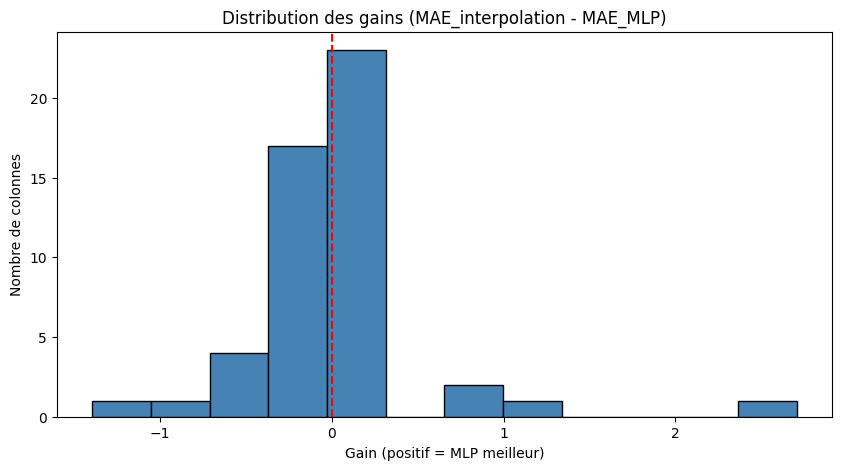

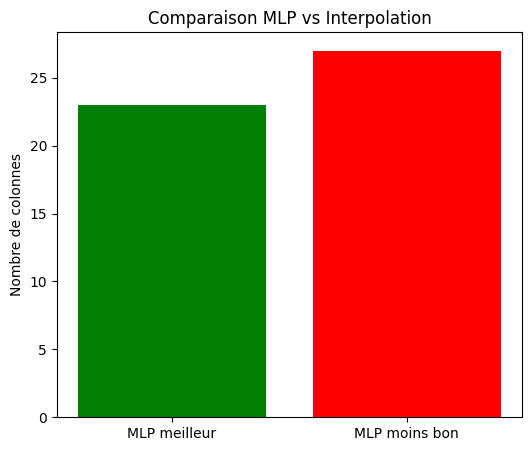

Colonnes ou MLP est meilleur : 23
 Colonnes ou l'interpolation est meilleure : 27

Pourcentage ameliore : 46.0%


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger tes résultats
df = pd.read_csv("resultats_MLP_global_50.csv")

# Histogramme des gains
plt.figure(figsize=(10,5))
plt.hist(df["gain"], bins=12, color="steelblue", edgecolor="black")
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution des gains (MAE_interpolation - MAE_MLP)")
plt.xlabel("Gain (positif = MLP meilleur)")
plt.ylabel("Nombre de colonnes")
plt.show()

# Nombre de colonnes améliorées / dégradées
nb_better = (df["gain"] > 0).sum()
nb_worse  = (df["gain"] <= 0).sum()

plt.figure(figsize=(6,5))
plt.bar(["MLP meilleur", "MLP moins bon"], [nb_better, nb_worse], 
        color=["green", "red"])
plt.title("Comparaison MLP vs Interpolation")
plt.ylabel("Nombre de colonnes")
plt.show()

print("Colonnes ou MLP est meilleur :", nb_better)
print(" Colonnes ou l'interpolation est meilleure :", nb_worse)

# Pourcentage
print(f"\nPourcentage ameliore : {100*nb_better/len(df):.1f}%")
